In [1]:
import tensorflow as tf

In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import math
import sys
#sys.path.insert(0,'/home/ikwak2/hmd/notebooks')
sys.path.insert(0,'lucashnegri-peakutils-51a679cd8428')
# sys.path.insert(0,'S1-S1-Phonocardiogram-Peak-Detection-Method-in-Python')
sys.path.insert(0,'utils')
from helper_code import *
from get_feature import *
from models import *
from Generator0 import *
from keras.preprocessing import sequence
# import peakutils
from scipy import special
import scipy.io as sio
from keras.preprocessing.sequence import pad_sequences
import peakutils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint

2022-08-11 18:43:59.894189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 18:43:59.913600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 18:43:59.914792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 18:43:59.916946: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
pwd

'/home/jk21/Documents/hmd/jk_classifier'

In [4]:
# data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_folder =  '/home/jk21/Downloads/Data/data/murmur/train'
test_folder = '/home/jk21/Downloads/Data/data/murmur/test'


In [5]:
model_folder = 'lcnn2'

In [6]:
model_folder

'lcnn2'

In [7]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    elif e > end:
        return lr_end

    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))

    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

In [8]:
patient_files_trn = find_patient_files(train_folder)
patient_files_test = find_patient_files(test_folder)

In [9]:


per_sec=16000
winlen = 512
hoplen = 256
nmel = 120 
nsec = 20 
trim = 1 
use_mel=True
use_cqt = False 
use_stft = False
use_raw=True
use_interval=True
use_wav2=False
maxlen1 = 246000
min_dist = 500
max_interval_len = 192


In [10]:
model1_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_folder,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)


In [11]:
model2_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_folder,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)    

In [12]:
params_feature = {'samp_sec': nsec,
                  #### melspec, stft 피쳐 옵션들  
                  'pre_emphasis': 0,
                  'hop_length': hoplen,
                  'win_length': winlen,
                  'n_mels': nmel,
                  #### cqt 피쳐 옵션들  
                  'filter_scale': 1,
                  'n_bins': 80,
                  'fmin': 10,
                  'maxlen1': maxlen1,
                  'min_dist':min_dist,
                  'max_interval_len' : max_interval_len,
                  'trim' :1,
                  'use_raw' : use_raw,
                  'use_mel' : use_mel,
                  'use_cqt' : use_cqt,
                  'use_stft' : use_stft,
                  'use_interval' : use_interval,
                  'use_wav2' : use_wav2,
                  'per_sec' : per_sec
}

In [13]:
params_feature = {'samp_sec': nsec,
                  #### melspec, stft 피쳐 옵션들  
                  'pre_emphasis': 0,
                  'hop_length': hoplen,
                  'win_length': winlen,
                  'n_mels': nmel,
                  #### cqt 피쳐 옵션들  
                  'filter_scale': 1,
                  'n_bins': 80,
                  'fmin': 10,
                  'maxlen1': maxlen1,
                  'min_dist':min_dist,
                  'max_interval_len' : max_interval_len,
                  'trim' :1,
                  'use_raw' : use_raw,
                  'use_mel' : use_mel,
                  'use_cqt' : use_cqt,
                  'use_stft' : use_stft,
                  'use_interval' : use_interval,
                  'use_wav2' : use_wav2,
                  'per_sec' : per_sec
}

In [14]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 120,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'maxlen1': 246000,
 'min_dist': 500,
 'max_interval_len': 192,
 'trim': 1,
 'use_raw': True,
 'use_mel': True,
 'use_cqt': False,
 'use_stft': False,
 'use_interval': True,
 'use_wav2': False,
 'per_sec': 16000}

In [16]:
features_trn, mel_input_shape, cqt_input_shape,stft_input_shape,interval_input_shape,raw1_input_shape = get_features_3lb_all_ord(train_folder, patient_files_trn, **params_feature)


100%|█████████████████████████████████████████| 751/751 [28:36<00:00,  2.29s/it]


melspec:  120 313
cqt:  1 1
stft:  1 1
interval:  192 1
raw1:  (246000,)


In [17]:
features_test, mel_input_shape, cqt_input_shape,stft_input_shape,interval_input_shape,raw1_input_shape= get_features_3lb_all_ord(test_folder, patient_files_test, **params_feature)

100%|█████████████████████████████████████████| 191/191 [08:00<00:00,  2.51s/it]


melspec:  120 313
cqt:  1 1
stft:  1 1
interval:  192 1
raw1:  (246000,)


In [15]:
mm_weight = 3 #np.random.choice([2,3,4,5])
oo_weight = 3 #np.random.choice([2,3,4,5,6])
ord1 = True #np.random.choice([True,False])
mm_mean = False #np.random.choice([True,False])
dp = 0 #np.random.choice([0, .1, .2, .3])
fc = False #np.random.choice([True,False])
ext = True
chaug = 10 #np.random.choice([0, 10])
mixup = True #np.random.choice([True,False])
cout = .8 #np.random.choice([0, 0.8])
wunknown = 1 #np.random.choice([1, 0.7, .5, .2])
n1 = 0 #np.random.choice([0,2])
if n1 == 0 :
    ranfil = False
else :
    ranfil = [n1, [18,19,20,21,22,23]]

In [16]:
params_feature['ord1'] = ord1
params_feature['mm_mean'] = mm_mean
params_feature['dp'] = dp
params_feature['fc'] = fc
params_feature['ext'] = ext
params_feature['oo_weight'] = oo_weight
params_feature['mm_weight'] = mm_weight
params_feature['chaug'] = chaug
params_feature['cout'] = cout
params_feature['wunknown'] = wunknown
params_feature['mixup'] = mixup
params_feature['n1'] = n1

In [17]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 120,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'maxlen1': 246000,
 'min_dist': 500,
 'max_interval_len': 192,
 'trim': 1,
 'use_raw': True,
 'use_mel': True,
 'use_cqt': False,
 'use_stft': False,
 'use_interval': True,
 'use_wav2': False,
 'per_sec': 16000,
 'ord1': True,
 'mm_mean': False,
 'dp': 0,
 'fc': False,
 'ext': True,
 'oo_weight': 3,
 'mm_weight': 3,
 'chaug': 10,
 'cout': 0.8,
 'wunknown': 1,
 'mixup': True,
 'n1': 0}

In [18]:
with open('/home/jk21/Downloads/Data/features_trn_wav2vec_include_interval_4sec.pickle', 'wb') as f:
    pickle.dump(features_trn, f, pickle.HIGHEST_PROTOCOL)

In [19]:
with open('/home/jk21/Downloads/Data/features_test_wav2vec_include_interval_4sec.pickle', 'wb') as f:
    pickle.dump(features_test, f, pickle.HIGHEST_PROTOCOL)

In [18]:
with open('/home/jk21/Downloads/Data/features_trn_wav2vec_include_interval_4sec.pickle', 'rb') as f:
    features_trn = pickle.load(f)

In [19]:
with open('/home/jk21/Downloads/Data/features_test_wav2vec_include_interval_4sec.pickle', 'rb') as f:
    features_test = pickle.load(f)

In [20]:
#################################################

In [21]:
# from skimage.transform import resize
# import matplotlib.pyplot as plt

In [18]:
# tmp_wav2 = np.zeros((2532,32,374,1))
# for i in range(len(features_trn['wav2'])):
#     test_ary=features_trn['wav2'][i]
#     res = resize(test_ary, (32,374,1))
#     tmp_wav2[i]=res
    

In [19]:
# features_trn['wav2'] = tmp_wav2

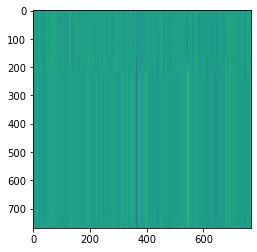

In [32]:
# plt.imshow(features_trn['wav2'][1])

In [20]:
# tmp_wav2 = np.zeros((631,32,374,1))
# for i in range(len(features_test['wav2'])):
#     test_ary=features_test['wav2'][i]
#     res = resize(test_ary, (32,374,1))
#     tmp_wav2[i]=res

In [21]:
# features_test['wav2'] = tmp_wav2

In [ ]:
##################################################

In [20]:
mel_input_shape = features_trn['mel1'].shape[1:]

In [21]:
mel_input_shape

(120, 313, 1)

In [22]:
cqt_input_shape = features_trn['cqt1'].shape[1:]

In [23]:
cqt_input_shape

(1, 1, 1)

In [24]:
stft_input_shape = features_trn['stft1'].shape[1:]

In [25]:
stft_input_shape

(1, 1, 1)

In [26]:
interval_input_shape= features_trn['interval'].shape[1:]

In [27]:
interval_input_shape

(192, 1)

In [28]:
wav2_input_shape= features_trn['wav2'].shape[1:]

In [29]:
wav2_input_shape

(32, 768)

In [30]:
raw1_input_shape= features_trn['raw1'].shape[1:]

In [31]:
raw1_input_shape

(246000,)

In [32]:
model1 = get_LCNN_o_4_dr_2(mel_input_shape, cqt_input_shape, stft_input_shape,interval_input_shape,wav2_input_shape,raw1_input_shape,use_mel = use_mel, use_raw=use_raw,use_wav2=use_wav2, ord1 = ord1,dp = dp, fc = fc, ext = ext)

In [33]:

model2 = get_LCNN_o_4_dr_2(mel_input_shape, cqt_input_shape, stft_input_shape,interval_input_shape,wav2_input_shape,raw1_input_shape,use_mel = use_mel, use_raw=use_raw,use_wav2=use_wav2, ord1 = ord1,dp = dp, fc = fc, ext = ext)


In [34]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 raw1 (InputLayer)              [(None, 246000)]     0           []                               
                                                                                                  
 reshape (Reshape)              (None, 300, 820)     0           ['raw1[0][0]']                   
                                                                                                  
 conv1d_20 (Conv1D)             (None, 300, 9)       22149       ['reshape[0][0]']                
                                                                                                  
 conv1d_21 (Conv1D)             (None, 300, 9)       22149       ['reshape[0][0]']                
                                                                                            

                                                                                                  
 max_pooling1d_17 (MaxPooling1D  (None, 292, 9)      0           ['maximum_17[0][0]']             
 )                                                                                                
                                                                                                  
 conv1d_36 (Conv1D)             (None, 292, 9)       171         ['max_pooling1d_17[0][0]']       
                                                                                                  
 conv1d_37 (Conv1D)             (None, 292, 9)       171         ['max_pooling1d_17[0][0]']       
                                                                                                  
 maximum_18 (Maximum)           (None, 292, 9)       0           ['conv1d_36[0][0]',              
                                                                  'conv1d_37[0][0]']              
          

                                                                                                  
 conv1d_45 (Conv1D)             (None, 288, 9)       171         ['max_pooling1d_21[0][0]']       
                                                                                                  
 conv2d_2 (Conv2D)              (None, 60, 157, 32)  1056        ['max_pooling2d[0][0]']          
                                                                                                  
 conv2d_3 (Conv2D)              (None, 60, 157, 32)  1056        ['max_pooling2d[0][0]']          
                                                                                                  
 maximum_2 (Maximum)            (None, 190, 9)       0           ['conv1d_4[0][0]',               
                                                                  'conv1d_5[0][0]']               
                                                                                                  
 maximum_2

 conv1d_50 (Conv1D)             (None, 285, 64)      1216        ['max_pooling1d_24[0][0]']       
                                                                                                  
 conv1d_51 (Conv1D)             (None, 285, 64)      1216        ['max_pooling1d_24[0][0]']       
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 30, 79, 48)  144         ['maximum_33[0][0]']             
 rmalization)                                                                                     
                                                                                                  
 maximum_5 (Maximum)            (None, 187, 9)       0           ['conv1d_10[0][0]',              
                                                                  'conv1d_11[0][0]']              
                                                                                                  
 maximum_2

                                                                                                  
 conv1d_17 (Conv1D)             (None, 184, 9)       171         ['max_pooling1d_7[0][0]']        
                                                                                                  
 conv1d_56 (Conv1D)             (None, 282, 9)       171         ['max_pooling1d_27[0][0]']       
                                                                                                  
 conv1d_57 (Conv1D)             (None, 282, 9)       171         ['max_pooling1d_27[0][0]']       
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 15, 40, 32)  96          ['maximum_36[0][0]']             
 rmalization)                                                                                     
                                                                                                  
 maximum_8

 dropout (Dropout)              (None, 9)            0           ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                                  
 dropout_1 (Dropout)            (None, 9)            0           ['global_average_pooling1d_1[0][0
                                                                 ]']                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 32)          0           ['max_pooling2d_3[0][0]']        
 alAveragePooling2D)                                                                              
                                                                                                  
 concatenate (Concatenate)      (None, 26)           0           ['dense_1[0][0]',                
          

In [35]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 raw1 (InputLayer)              [(None, 246000)]     0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 300, 820)     0           ['raw1[0][0]']                   
                                                                                                  
 conv1d_80 (Conv1D)             (None, 300, 9)       22149       ['reshape_1[0][0]']              
                                                                                                  
 conv1d_81 (Conv1D)             (None, 300, 9)       22149       ['reshape_1[0][0]']              
                                                                                            

                                                                                                  
 max_pooling1d_47 (MaxPooling1D  (None, 292, 9)      0           ['maximum_56[0][0]']             
 )                                                                                                
                                                                                                  
 conv1d_96 (Conv1D)             (None, 292, 9)       171         ['max_pooling1d_47[0][0]']       
                                                                                                  
 conv1d_97 (Conv1D)             (None, 292, 9)       171         ['max_pooling1d_47[0][0]']       
                                                                                                  
 maximum_57 (Maximum)           (None, 292, 9)       0           ['conv1d_96[0][0]',              
                                                                  'conv1d_97[0][0]']              
          

                                                                                                  
 conv1d_104 (Conv1D)            (None, 288, 9)       171         ['max_pooling1d_51[0][0]']       
                                                                                                  
 conv1d_105 (Conv1D)            (None, 288, 9)       171         ['max_pooling1d_51[0][0]']       
                                                                                                  
 conv2d_20 (Conv2D)             (None, 60, 157, 32)  1056        ['max_pooling2d_4[0][0]']        
                                                                                                  
 conv2d_21 (Conv2D)             (None, 60, 157, 32)  1056        ['max_pooling2d_4[0][0]']        
                                                                                                  
 maximum_41 (Maximum)           (None, 190, 9)       0           ['conv1d_64[0][0]',              
          

                                                                                                  
 conv1d_70 (Conv1D)             (None, 187, 9)       171         ['max_pooling1d_34[0][0]']       
                                                                                                  
 conv1d_71 (Conv1D)             (None, 187, 9)       171         ['max_pooling1d_34[0][0]']       
                                                                                                  
 conv1d_110 (Conv1D)            (None, 285, 64)      1216        ['max_pooling1d_54[0][0]']       
                                                                                                  
 conv1d_111 (Conv1D)            (None, 285, 64)      1216        ['max_pooling1d_54[0][0]']       
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 30, 79, 48)  144         ['maximum_72[0][0]']             
 rmalizati

                                                                                                  
 max_pooling1d_57 (MaxPooling1D  (None, 282, 9)      0           ['maximum_66[0][0]']             
 )                                                                                                
                                                                                                  
 maximum_75 (Maximum)           (None, 15, 40, 32)   0           ['conv2d_30[0][0]',              
                                                                  'conv2d_31[0][0]']              
                                                                                                  
 conv1d_76 (Conv1D)             (None, 184, 9)       171         ['max_pooling1d_37[0][0]']       
                                                                                                  
 conv1d_77 (Conv1D)             (None, 184, 9)       171         ['max_pooling1d_37[0][0]']       
          

 dense_7 (Dense)                (None, 2)            14          ['age_cat[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 1)            3           ['sex_cat[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 1)            3           ['height_weight[0][0]']          
                                                                                                  
 dense_10 (Dense)               (None, 3)            18          ['loc[0][0]']                    
                                                                                                  
 is_preg (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dropout_3

In [36]:
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64

if mixup :
    beta_param = .7
else :
    beta_param = 0
    


params = {'batch_size': batch_size,
          #          'input_shape': (100, 313, 1),
          'shuffle': True,
          'chaug': chaug,
          'beta_param': beta_param,
          'cout': cout
#              'mixup': mixup,
          #          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          #          'highpass': [.5, [78,79,80,81,82,83,84,85]]
#              'ranfilter2' : [3, [18,19,20,21,22,23]]
          #           'dropblock' : [30, 100]
          #'device' : device
}

if mixup :
    params['mixup'] = mixup
    params['ranfilter2'] = ranfil
else :
    params['cutout'] = cout

params_no_shuffle = {'batch_size': batch_size,
                     #          'input_shape': (100, 313, 1),
                     'shuffle': False,
                     'beta_param': 0.7,
                     'mixup': False
                     #'device': device
}


# TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], features_trn['preg'], features_trn['loc'],
#             features_trn['interval'],features_trn['wav2'],features_trn['mel1'],features_trn['cqt1'],features_trn['stft1']], 
#            features_trn['mm_labels'],  ## our Y
#                         **params)()


# ValidDGen_1 = Generator0([features_test['age'],features_test['sex'], features_test['hw'], 
#                               features_test['preg'], features_test['loc'],features_test['interval'],
#                               features_test['wav2'], features_test['mel1'],features_test['cqt1'],features_test['stft1']], 
#                              features_test['mm_labels'],  ## our Y
                         
#                          **params)()





if ord1 :
    class_weight = {0: mm_weight, 1: 1.}
else :
    class_weight = {0: mm_weight, 1: wunknown, 2:1.}

    
    
    
    

if mixup :
    
    
    TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], 
                              features_trn['preg'], features_trn['loc'],features_trn['raw1'],features_trn['interval'],
                              features_trn['wav2'],
                              features_trn['mel1'],
                              features_trn['cqt1'],
                              features_trn['stft1']],features_trn['mm_labels'],**params)()
    
    model1.fit(TrainDGen_1,
               validation_data = ([features_test['age'],features_test['sex'], features_test['hw'],                                   
                                   features_test['preg'], features_test['loc'],features_test['raw1'],
                                   features_test['interval'],features_test['wav2'],
                                   features_test['mel1'],
                                   features_test['cqt1'],
                                   features_test['stft1']],features_test['mm_labels']),
               
               callbacks=[lr,model1_callback],
               steps_per_epoch=np.ceil(len(features_trn['mm_labels'])/batch_size),
               class_weight=class_weight, 
               epochs = n_epoch)
    
    
 


Epoch 1/100


2022-08-11 18:44:20.848541: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


40/40 [==============================] - 15s 190ms/step - loss: 2.0427 - accuracy: 0.7312 - auc: 0.7434 - val_loss: 1.7202 - val_accuracy: 0.2076 - val_auc: 0.1565 - lr: 9.9851e-04
Epoch 2/100
40/40 [==============================] - 5s 122ms/step - loss: 0.8778 - accuracy: 0.7992 - auc: 0.8641 - val_loss: 0.6705 - val_accuracy: 0.7892 - val_auc: 0.8440 - lr: 9.9831e-04
Epoch 3/100
40/40 [==============================] - 7s 170ms/step - loss: 0.8656 - accuracy: 0.8094 - auc: 0.8614 - val_loss: 0.5380 - val_accuracy: 0.8051 - val_auc: 0.8742 - lr: 9.9807e-04
Epoch 4/100
40/40 [==============================] - 6s 164ms/step - loss: 0.8494 - accuracy: 0.8070 - auc: 0.8636 - val_loss: 0.5780 - val_accuracy: 0.8003 - val_auc: 0.8752 - lr: 9.9781e-04
Epoch 5/100
40/40 [==============================] - 7s 168ms/step - loss: 0.8532 - accuracy: 0.8039 - auc: 0.8652 - val_loss: 0.6082 - val_accuracy: 0.8003 - val_auc: 0.8649 - lr: 9.9750e-04
Epoch 6/100
40/40 [==============================] 

40/40 [==============================] - 7s 180ms/step - loss: 0.7575 - accuracy: 0.8434 - auc: 0.8944 - val_loss: 0.3483 - val_accuracy: 0.8970 - val_auc: 0.9441 - lr: 7.4146e-04
Epoch 44/100
40/40 [==============================] - 7s 176ms/step - loss: 0.8140 - accuracy: 0.8141 - auc: 0.8909 - val_loss: 0.3943 - val_accuracy: 0.8986 - val_auc: 0.9058 - lr: 7.1587e-04
Epoch 45/100
40/40 [==============================] - 7s 167ms/step - loss: 0.7996 - accuracy: 0.8156 - auc: 0.8889 - val_loss: 0.5937 - val_accuracy: 0.7179 - val_auc: 0.8025 - lr: 6.8882e-04
Epoch 46/100
40/40 [==============================] - 7s 173ms/step - loss: 0.7785 - accuracy: 0.8238 - auc: 0.8972 - val_loss: 0.3365 - val_accuracy: 0.8970 - val_auc: 0.9332 - lr: 6.6044e-04
Epoch 47/100
40/40 [==============================] - 7s 174ms/step - loss: 0.7800 - accuracy: 0.8258 - auc: 0.8897 - val_loss: 0.3940 - val_accuracy: 0.8780 - val_auc: 0.9188 - lr: 6.3088e-04
Epoch 48/100
40/40 [============================

40/40 [==============================] - 7s 169ms/step - loss: 0.7727 - accuracy: 0.8164 - auc: 0.9032 - val_loss: 0.3869 - val_accuracy: 0.8954 - val_auc: 0.9423 - lr: 2.1772e-05
Epoch 86/100
40/40 [==============================] - 7s 169ms/step - loss: 0.7555 - accuracy: 0.8316 - auc: 0.9050 - val_loss: 0.3622 - val_accuracy: 0.9081 - val_auc: 0.9451 - lr: 2.0352e-05
Epoch 87/100
40/40 [==============================] - 7s 170ms/step - loss: 0.7683 - accuracy: 0.8273 - auc: 0.9059 - val_loss: 0.3701 - val_accuracy: 0.9002 - val_auc: 0.9464 - lr: 1.9102e-05
Epoch 88/100
40/40 [==============================] - 7s 169ms/step - loss: 0.7650 - accuracy: 0.8250 - auc: 0.9020 - val_loss: 0.3842 - val_accuracy: 0.8986 - val_auc: 0.9456 - lr: 1.8001e-05
Epoch 89/100
40/40 [==============================] - 7s 168ms/step - loss: 0.7908 - accuracy: 0.8098 - auc: 0.8999 - val_loss: 0.3934 - val_accuracy: 0.8938 - val_auc: 0.9438 - lr: 1.7033e-05
Epoch 90/100
40/40 [============================

In [37]:
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))

batch_size = 64

if mixup :
    beta_param = .7
else :
    beta_param = 0
    
params = {'batch_size': batch_size,
          #          'input_shape': (100, 313, 1),
          'shuffle': True,
          'chaug': 0,
          'beta_param': beta_param,
          'cout': cout,
#              'mixup': True,
          #          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#            'highpass': [.5, [78,79,80,81,82,83,84,85]],
#              'ranfilter2' : [3, [18,19,20,21,22,23]]
        #           'dropblock' : [30, 100]
          #'device' : device
}



if mixup :
    params['mixup'] = mixup
    params['ranfilter2'] = ranfil
else :
    params['cutout'] = cout


params_no_shuffle = {'batch_size': batch_size,
                     #          'input_shape': (100, 313, 1),
                     'shuffle': False,
                     'beta_param': 0.7,
                     'mixup': False
                     #'device': device
}




if mixup :

    
    class_weight = {0: oo_weight, 1: 1.}
    TrainDGen_1 = Generator0([features_trn['age'],features_trn['sex'], features_trn['hw'], 
                              features_trn['preg'], features_trn['loc'],features_trn['raw1'],features_trn['interval'],
                              features_trn['wav2'],
                              features_trn['mel1'],
                              features_trn['cqt1'],
                              features_trn['stft1']],features_trn['out_labels'],**params)()

    model2.fit(TrainDGen_1,
               validation_data = ([features_test['age'],features_test['sex'], features_test['hw'],                                   
                                   features_test['preg'], features_test['loc'],features_test['raw1'],
                                   features_test['interval'],features_test['wav2'],
                                   features_test['mel1'],
                                   features_test['cqt1'],
                                   features_test['stft1']],features_test['out_labels']), 
               
               callbacks=[lr,model2_callback],
               steps_per_epoch=np.ceil(len(features_trn['out_labels'])/batch_size),
               class_weight=class_weight, 
               epochs = n_epoch)
    


Epoch 1/100
40/40 [==============================] - 15s 248ms/step - loss: 36.7219 - accuracy: 0.5090 - auc: 0.5033 - val_loss: 1.2797 - val_accuracy: 0.5008 - val_auc: 0.5272 - lr: 9.9851e-04
Epoch 2/100
40/40 [==============================] - 5s 125ms/step - loss: 1.3877 - accuracy: 0.4637 - auc: 0.4781 - val_loss: 2.2916 - val_accuracy: 0.4992 - val_auc: 0.4309 - lr: 9.9831e-04
Epoch 3/100
40/40 [==============================] - 7s 171ms/step - loss: 1.2412 - accuracy: 0.4879 - auc: 0.5014 - val_loss: 1.6222 - val_accuracy: 0.4992 - val_auc: 0.4382 - lr: 9.9807e-04
Epoch 4/100
40/40 [==============================] - 7s 179ms/step - loss: 1.2417 - accuracy: 0.4980 - auc: 0.5169 - val_loss: 1.2235 - val_accuracy: 0.4992 - val_auc: 0.4653 - lr: 9.9781e-04
Epoch 5/100
40/40 [==============================] - 7s 172ms/step - loss: 1.2187 - accuracy: 0.4785 - auc: 0.5102 - val_loss: 0.8265 - val_accuracy: 0.4992 - val_auc: 0.5247 - lr: 9.9750e-04
Epoch 6/100
40/40 [===================

40/40 [==============================] - 7s 175ms/step - loss: 1.1872 - accuracy: 0.4730 - auc: 0.5510 - val_loss: 0.6443 - val_accuracy: 0.5674 - val_auc: 0.6403 - lr: 7.4146e-04
Epoch 44/100
40/40 [==============================] - 7s 178ms/step - loss: 1.1974 - accuracy: 0.4859 - auc: 0.5499 - val_loss: 0.7022 - val_accuracy: 0.5943 - val_auc: 0.6469 - lr: 7.1587e-04
Epoch 45/100
40/40 [==============================] - 7s 178ms/step - loss: 1.1849 - accuracy: 0.4832 - auc: 0.5453 - val_loss: 0.7997 - val_accuracy: 0.4992 - val_auc: 0.5796 - lr: 6.8882e-04
Epoch 46/100
40/40 [==============================] - 7s 175ms/step - loss: 1.1639 - accuracy: 0.4855 - auc: 0.5832 - val_loss: 0.6789 - val_accuracy: 0.5468 - val_auc: 0.6280 - lr: 6.6044e-04
Epoch 47/100
40/40 [==============================] - 7s 174ms/step - loss: 1.1921 - accuracy: 0.4766 - auc: 0.5538 - val_loss: 0.8644 - val_accuracy: 0.4992 - val_auc: 0.5822 - lr: 6.3088e-04
Epoch 48/100
40/40 [============================

40/40 [==============================] - 7s 175ms/step - loss: 1.1521 - accuracy: 0.5109 - auc: 0.6118 - val_loss: 0.7233 - val_accuracy: 0.5246 - val_auc: 0.5819 - lr: 2.1772e-05
Epoch 86/100
40/40 [==============================] - 7s 175ms/step - loss: 1.1356 - accuracy: 0.5273 - auc: 0.6207 - val_loss: 0.7354 - val_accuracy: 0.5309 - val_auc: 0.5791 - lr: 2.0352e-05
Epoch 87/100
40/40 [==============================] - 7s 174ms/step - loss: 1.1486 - accuracy: 0.5367 - auc: 0.6173 - val_loss: 0.7398 - val_accuracy: 0.5309 - val_auc: 0.5794 - lr: 1.9102e-05
Epoch 88/100
40/40 [==============================] - 7s 174ms/step - loss: 1.1609 - accuracy: 0.5332 - auc: 0.6129 - val_loss: 0.7131 - val_accuracy: 0.5309 - val_auc: 0.5892 - lr: 1.8001e-05
Epoch 89/100
40/40 [==============================] - 7s 173ms/step - loss: 1.1574 - accuracy: 0.5164 - auc: 0.6123 - val_loss: 0.7063 - val_accuracy: 0.5357 - val_auc: 0.5892 - lr: 1.7033e-05
Epoch 90/100
40/40 [============================

In [38]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 120,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'maxlen1': 246000,
 'min_dist': 500,
 'max_interval_len': 192,
 'trim': 1,
 'use_raw': True,
 'use_mel': True,
 'use_cqt': False,
 'use_stft': False,
 'use_interval': True,
 'use_wav2': False,
 'per_sec': 16000,
 'ord1': True,
 'mm_mean': False,
 'dp': 0,
 'fc': False,
 'ext': True,
 'oo_weight': 3,
 'mm_weight': 3,
 'chaug': 10,
 'cout': 0.8,
 'wunknown': 1,
 'mixup': True,
 'n1': 0}

In [39]:
params_feature['mel_shape'] = mel_input_shape
params_feature['cqt_shape'] = cqt_input_shape
params_feature['stft_shape'] = stft_input_shape
params_feature['interval_input_shape'] = interval_input_shape
params_feature['raw1_input_shape'] = raw1_input_shape
params_feature['wav2_input_shape'] = wav2_input_shape
params_feature['max_interval_len'] = max_interval_len

In [40]:
params_feature

{'samp_sec': 20,
 'pre_emphasis': 0,
 'hop_length': 256,
 'win_length': 512,
 'n_mels': 120,
 'filter_scale': 1,
 'n_bins': 80,
 'fmin': 10,
 'maxlen1': 246000,
 'min_dist': 500,
 'max_interval_len': 192,
 'trim': 1,
 'use_raw': True,
 'use_mel': True,
 'use_cqt': False,
 'use_stft': False,
 'use_interval': True,
 'use_wav2': False,
 'per_sec': 16000,
 'ord1': True,
 'mm_mean': False,
 'dp': 0,
 'fc': False,
 'ext': True,
 'oo_weight': 3,
 'mm_weight': 3,
 'chaug': 10,
 'cout': 0.8,
 'wunknown': 1,
 'mixup': True,
 'n1': 0,
 'mel_shape': (120, 313, 1),
 'cqt_shape': (1, 1, 1),
 'stft_shape': (1, 1, 1),
 'interval_input_shape': (192, 1),
 'raw1_input_shape': (246000,),
 'wav2_input_shape': (32, 768)}

In [41]:
#확인

In [42]:
import pickle as pk
def save_challenge_model(model_folder, model1, model2, m_name1, m_name2, param_feature) :
    os.makedirs(model_folder, exist_ok=True)
    info_fnm = os.path.join(model_folder, 'desc.pk')
    filename1 = os.path.join(model_folder, m_name1 + '_model1.hdf5')
    filename2 = os.path.join(model_folder, m_name2 + '_model2.hdf5')
    model1.save(filename1)
    model2.save(filename2)
    param_feature['model1'] = m_name1
    param_feature['model2'] = m_name2
    param_feature['model_fnm1'] = filename1
    param_feature['model_fnm2'] = filename2
    with open(info_fnm, 'wb') as f:
        pk.dump(param_feature, f, pk.HIGHEST_PROTOCOL)
    return 1

    with open(info_fnm, 'wb') as f:
        pk.dump(param_feature, f, pk.HIGHEST_PROTOCOL)
    return 1
    

In [43]:
model_folder

'lcnn2'

In [44]:
save_challenge_model(model_folder, model1, model2, m_name1 = 'lcnn1', m_name2 = 'lcnn2', param_feature = params_feature)

1

In [45]:
def load_challenge_model(model_folder, verbose):
    info_fnm = os.path.join(model_folder, 'desc.pk')
    with open(info_fnm, 'rb') as f:
        info_m = pk.load(f)

    return info_m

In [46]:
def run_challenge_model(model, data, recordings, verbose):
    
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Abnormal', 'Normal']

##########################################################################    
    if model['model1'] == 'lcnn1' :
        model1 = get_LCNN_o_4_dr_2(model['mel_shape'],model['cqt_shape'],model['stft_shape'], model['interval_input_shape'],
                                   model['wav2_input_shape'],model['raw1_input_shape'], 
                                   use_mel = model['use_mel'],use_cqt = model['use_cqt'], use_stft = model['use_stft'], 
                                 ord1 = model['ord1'], dp = model['dp'], fc = model['fc'], ext = model['ext'],
                                   use_wav2=model['use_wav2'],use_raw=model['use_raw'])  
    if model['model2'] == 'lcnn2' :
        model2 = get_LCNN_o_4_dr_2(model['mel_shape'],model['cqt_shape'],model['stft_shape'], model['interval_input_shape'],
                                   model['wav2_input_shape'],model['raw1_input_shape'], 
                                   use_mel = model['use_mel'],use_cqt = model['use_cqt'], use_stft = model['use_stft'], 
                                 ord1 = model['ord1'], dp = model['dp'], fc = model['fc'], ext = model['ext'],
                                   use_wav2=model['use_wav2'],use_raw=model['use_raw'])   
    model1.load_weights(model['model_fnm1'])
    model2.load_weights(model['model_fnm2'])
############################################################################ 


    maxlen1 = params_feature['maxlen1']
    min_dist = params_feature['min_dist']
    max_interval_len = params_feature['max_interval_len']
    
    
    # Load features.
    features = get_feature_one(data, verbose = 0)

    samp_sec = model['samp_sec'] 
    pre_emphasis = model['pre_emphasis']
    hop_length = model['hop_length']
    win_length = model['win_length']
    n_mels = model['n_mels']
    filter_scale = model['filter_scale']
    n_bins = model['n_bins']
    fmin = model['fmin']
    trim = model['trim']
    use_mel = model['use_mel']
    use_cqt = model['use_cqt']
    use_stft = model['use_stft']
    use_interval = model['use_interval']
    use_wav2 = model['use_wav2']
    maxlen1 = model['maxlen1']
    min_dist = model['min_dist']
    per_sec = model['per_sec']
    
#    use_raw = model['use_raw']

    

    features['raw1'] = []
    tmp_wav=[] 
    if use_raw:

        for i in range(len(recordings)):
            data = recordings[i]
            tmp_wav.append(data)

        padded =pad_sequences(tmp_wav, maxlen=maxlen1, dtype='float64', padding='post', truncating='post', value=0.0)

        padded=np.array(padded, dtype=np.float32)
        for i in range(len(padded)):
            features['raw1'].append(padded[i])

        features['raw1'] = np.array(features['raw1'])
  
    
      
    features['wav2'] = []
    if use_wav2:
        
        
        
        tmp_pad = padded[:,np.newaxis,:]
        
        tmp=[]
        for i in range(len(tmp_pad)):
            tmp_feature = wav2vec_model(tmp_pad[i])
            tmp.append(tmp_feature)
            
        tmp=np.array(tmp, dtype=np.float32)
        new_tmp1=tmp.reshape(-1,32,768)
        features['wav2']=new_tmp1
    else:
        M,N = model['wav2_input_shape']
        new_tmp1 = np.zeros((padded.shape[0],M,N))
        features['wav2']=new_tmp1
        
    features['interval'] = []
    tmp_total_interval = [] 
       
    if use_interval:


        for i in tqdm.tqdm(range(len(recordings))) :
            
            datos=recordings[i]
            filtros=sio.loadmat('./Filters1')
            tmp_interval = []
            n_samp = len(datos)//per_sec


            try:
                for k in range(n_samp):
                    
                    X = datos[k*per_sec:(k+1)*per_sec]
                    Fs= per_sec
                    Fpa20=filtros['Fpa20'];			        # High pass filter
                    Fpa20=Fpa20[0];					# High pass filter
                    Fpb100=filtros['Fpb100'];		        # Low-pass Filter
                    Fpb100=Fpb100[0];				# Low-pass Filter
                    Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
                    Xf=vec_nor(Xf);			

                # Derivate of the Signal
                    dX=derivate(Xf);				# Derivate of the signal
                    dX=vec_nor(dX);					# Vector Normalizing
                # Square of the signal
                    dy=np.square(Xf);
                    dy=vec_nor(dy);

                    size=np.shape(Xf)				# Rank or dimension of the array
                    fil=size[0];					# Number of rows

                    positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
                    positive=positive[0];                           # Getting the Vector

                    points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
                    points=points[0];                               # Getting the point vector

                    peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
                    peaks=peaks[0];                                 # Getting the point vector


                    for i in range(0,fil):
                        if dX[i]>0:
                            positive[i]=1;
                        else:
                            positive[i]=0;

                    for i in range(0,fil):
                        if (positive[i]==1 and positive[i+1]==0):
                            points[i]=Xf[i];
                        else:
                            points[i]=0;

                    indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
                    lenght=np.shape(indexes)			# Get the length of the index vector		
                    lenght=lenght[0];				# Get the value of the index vector

                    for i in range(0,lenght):
                        p=indexes[i];
                        peaks[p]=points[p];

                    n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
                    indexes =indexes+(k*per_sec)    
                    tmp_peaks = np.array(indexes)


                    tmp_interval.extend(tmp_peaks)

                tmp_interval = np.array(tmp_interval)
                tmp_interval = np.diff(tmp_interval)

                tmp_total_interval.append(tmp_interval)


            except:
                print(i)
                tmp_peaks = np.zeros(max_interval_len)
                tmp_total_interval.append(tmp_peaks)

    else :

        tmp_peaks = np.zeros(max_interval_len)
        tmp_total_interval.append(tmp_peaks)       


    if use_interval:
          
        padded =pad_sequences(tmp_total_interval, maxlen=max_interval_len, dtype='float64', padding='post', truncating='post', value=0.0)

        for i in range(len(padded)):
            features['interval'].append(padded[i])
             
        for i in range(len(features['interval'])):
            features['interval'][i]= features['interval'][i].reshape(-1,1)
    
        features['interval']=np.array(features['interval'])
    
        
    else:
        for i in range(len(tmp_interval)):
            features['interval'].append(tmp_total_interval[i])
        
        for i in range(len(features['interval'])):
            features['interval'][i]= features['interval'][i].reshape(-1,1)
        features['interval']=np.array(features['interval'])
    
    
    
    features['mel1'] = []
    for i in range(len(recordings)) :
        if use_mel :
            mel1 = feature_extract_melspec(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                           win_length = win_length, n_mels = n_mels)[0]
        else :
            mel1 = np.zeros( (1,1) )
            
        features['mel1'].append(mel1)
        
    M, N = features['mel1'][0].shape
    
    if use_mel :
        for i in range(len(features['mel1'])) :
            features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
    
    features['mel1'] = np.array(features['mel1'])

    
  
    features['cqt1'] = []
    for i in range(len(recordings)) :
        if use_cqt :
            mel1 = feature_extract_cqt(recordings[i], samp_sec=samp_sec, pre_emphasis = pre_emphasis, filter_scale = filter_scale, 
                                        n_bins = n_bins, fmin = fmin)[0]
        else:
            mel1 = np.zeros( (1,1,1) )
            
        features['cqt1'].append(mel1)
        
    M, N,__ = features['cqt1'][0].shape
    
    if use_cqt :
        for i in range(len(features['cqt1'])) :
            features['cqt1'][i] = features['cqt1'][i].reshape(M,N,1)   
    
    features['cqt1'] = np.array(features['cqt1'])
    
    
    features['stft1'] = []
    for i in range(len(recordings)) :
        if use_stft :
            mel1 = feature_extract_stft(recordings[i]/ 32768, samp_sec=samp_sec, pre_emphasis = pre_emphasis, hop_length=hop_length, 
                                        win_length = win_length)[0]
        else :
            mel1 = np.zeros( (1,1,1) )
        
        features['stft1'].append(mel1)
        
    M, N,__ = features['stft1'][0].shape
    if use_stft :
        for i in range(len(features['stft1'])) :
            features['stft1'][i] = features['stft1'][i].reshape(M,N,1)           
    features['stft1'] = np.array(features['stft1'])
    
#     return features       

    #    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], 
                           features['loc'], features['raw1'],features['interval'],features['wav2'],features['mel1'], features['stft1'], features['cqt1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], 
                           features['loc'], features['raw1'],features['interval'],features['wav2'],features['mel1'], features['stft1'], features['cqt1']])
    if model['ord1'] :
        idx1 = res1.argmax(axis=0)[0]
        murmur_p = res1[idx1,]  ## mumur 확률 최대화 되는 애 뽑기ddd
        murmur_probabilities = np.zeros((3,))
        murmur_probabilities[0] = murmur_p[0]
        murmur_probabilities[1] = 0
        murmur_probabilities[2] = murmur_p[1]
        outcome_probabilities = res2.mean(axis = 0) ##  outcome 은 그냥 평균으로 뽑기
    else :
        if model['mm_mean'] :
            murmur_probabilities = res1.mean(axis = 0)
        else :
            idx1 = res1.argmax(axis=0)[0]
            murmur_probabilities = res1[idx1,]  ## mumur 확률 최대화 되는 애 뽑기
        outcome_probabilities = res2.mean(axis = 0) ##  outcome 은 그냥 평균으로 뽑기

        
    murmur_labels = np.zeros(len(murmur_classes), dtype=np.int_)
    
    
    if murmur_probabilities[0] > 0.482 :
        idx = 0
    else :
        idx = 2
    murmur_labels[idx] = 1

    outcome_labels = np.zeros(len(outcome_classes), dtype=np.int_)
    if outcome_probabilities[0] > 0.607 :
        idx = 0
    else :
        idx = 1    
        # idx = np.argmax(outcome_probabilities)
    outcome_labels[idx] = 1
    
    # Concatenate classes, labels, and probabilities.
    classes = murmur_classes + outcome_classes
    labels = np.concatenate((murmur_labels, outcome_labels))
    probabilities = np.concatenate((murmur_probabilities, outcome_probabilities))
    
    return classes, labels, probabilities

In [47]:
model_folder

'lcnn2'

In [48]:
data_folder = test_folder

In [49]:
data_folder

'/home/jk21/Downloads/Data/data/murmur/test'

In [50]:
output_folder ='/home/jk21/Documents/hmd/jk_classifier/out_lcnn2'

In [51]:
allow_failures=True

In [52]:
verbose=1

In [53]:
model = load_challenge_model(model_folder, verbose)

In [54]:
patient_files = find_patient_files(data_folder)

In [55]:
num_patient_files = len(patient_files)

In [56]:
patient_data = load_patient_data(patient_files[0])

In [57]:
patient_data

'33151 4 4000\nAV 33151_AV.hea 33151_AV.wav 33151_AV.tsv\nPV 33151_PV.hea 33151_PV.wav 33151_PV.tsv\nTV 33151_TV.hea 33151_TV.wav 33151_TV.tsv\nMV 33151_MV.hea 33151_MV.wav 33151_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 141.0\n#Weight: 30.9\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: MV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Plateau\n#Systolic murmur grading: I/VI\n#Systolic murmur pitch: Low\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

In [58]:
recordings = load_recordings(data_folder, patient_data)

In [59]:
classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose)

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.69it/s]


In [60]:
probabilities

array([0.78276169, 0.        , 0.21723829, 0.77193379, 0.22806621])

In [61]:
classes

['Present', 'Unknown', 'Absent', 'Abnormal', 'Normal']

In [62]:
# Run model.
def run_model(model_folder, data_folder, output_folder, allow_failures, verbose=1):
    # Load models.
    if verbose >= 1:
        print('Loading Challenge model...')

    model = load_challenge_model(model_folder, verbose) ### Teams: Implement this function!!!

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)

    if num_patient_files==0:
        raise Exception('No data was provided.')

    # Create a folder for the Challenge outputs if it does not already exist.
    os.makedirs(output_folder, exist_ok=True)

    # Run the team's model on the Challenge data.
    if verbose >= 1:
        print('Running model on Challenge data...')

    # Iterate over the patient files.
    for i in range(num_patient_files):
        if verbose >= 2:
            print('    {}/{}...'.format(i+1, num_patient_files))

        patient_data = load_patient_data(patient_files[i])
        recordings = load_recordings(data_folder, patient_data)

        # Allow or disallow the model to fail on parts of the data; helpful for debugging.
        try:
            classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose) ### Teams: Implement this function!!!
        except:
            if allow_failures:
                if verbose >= 2:
                    print('... failed.')
                classes, labels, probabilities = list(), list(), list()
            else:
                raise

        # Save Challenge outputs.
        head, tail = os.path.split(patient_files[i])
        root, extension = os.path.splitext(tail)
        output_file = os.path.join(output_folder, root + '.csv')
        patient_id = get_patient_id(patient_data)
        save_challenge_outputs(output_file, patient_id, classes, labels, probabilities)

    if verbose >= 1:
        print('Done.')

In [63]:
test_folder

'/home/jk21/Downloads/Data/data/murmur/test'

In [64]:
output_folder = '/home/jk21/Documents/hmd/jk_classifier/out_lcnn2'

In [65]:
model_folder

'lcnn2'

In [66]:
run_model(model_folder, test_folder, output_folder, allow_failures = True, verbose = 2)

Loading Challenge model...
Running model on Challenge data...
    1/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.42it/s]


    2/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s]


    3/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07it/s]


    4/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


    5/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.48it/s]


    6/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


    7/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]


    8/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.48it/s]


    9/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.74it/s]


    10/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]


    11/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]


    12/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]


    13/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.02it/s]


    14/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.20it/s]


    15/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


    16/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.26it/s]


    17/191...


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


    18/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.70it/s]


    19/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


    20/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


    21/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s]


    22/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.76it/s]


    23/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.41it/s]


    24/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


    25/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.29it/s]


    26/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.91it/s]


    27/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.41it/s]


    28/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


    29/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.02it/s]


    30/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]


    31/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.83it/s]


    32/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


    33/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


    34/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.41it/s]


    35/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


    36/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.71it/s]


    37/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.83it/s]


    38/191...


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.16it/s]


    39/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.73it/s]


    40/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s]


    41/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


    42/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.47it/s]


    43/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.89it/s]


    44/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s]


    45/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.34it/s]


    46/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03it/s]


    47/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.80it/s]


    48/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.77it/s]


    49/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


    50/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.49it/s]


    51/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


    52/191...


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


    53/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


    54/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.50it/s]


    55/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.29it/s]


    56/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.17it/s]


    57/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.48it/s]


    58/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


    59/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


    60/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.88it/s]


    61/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.85it/s]


    62/191...


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


    63/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]


    64/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


    65/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.11it/s]


    66/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


    67/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26it/s]


    68/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]


    69/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.87it/s]


    70/191...


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.74it/s]


    71/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


    72/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


    73/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.43it/s]


    74/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]


    75/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


    76/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.81it/s]


    77/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95it/s]


    78/191...


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75it/s]


    79/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]


    80/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


    81/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.06it/s]


    82/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.65it/s]


    83/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]


    84/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


    85/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


    86/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.06it/s]


    87/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


    88/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.72it/s]


    89/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.77it/s]


    90/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]


    91/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.74it/s]


    92/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.62it/s]


    93/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28it/s]


    94/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60it/s]


    95/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.42it/s]


    96/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


    97/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.72it/s]


    98/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


    99/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]


    100/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.15it/s]


    101/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


    102/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.09it/s]


    103/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.72it/s]


    104/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 17.86it/s]


    105/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


    106/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]


    107/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


    108/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


    109/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.27it/s]


    110/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.93it/s]


    111/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78it/s]


    112/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


    113/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82it/s]


    114/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]


    115/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


    116/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


    117/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


    118/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


    119/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


    120/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


    121/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.89it/s]


    122/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.75it/s]


    123/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


    124/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10it/s]


    125/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92it/s]


    126/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


    127/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.04it/s]


    128/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


    129/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.92it/s]


    130/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26it/s]


    131/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.04it/s]


    132/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


    133/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.98it/s]


    134/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


    135/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.22it/s]


    136/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


    137/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]


    138/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.99it/s]


    139/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


    140/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.59it/s]


    141/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.57it/s]


    142/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.46it/s]


    143/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


    144/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22it/s]


    145/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


    146/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.39it/s]


    147/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


    148/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81it/s]


    149/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.19it/s]


    150/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84it/s]


    151/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54it/s]


    152/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.95it/s]


    153/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.65it/s]


    154/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]


    155/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]


    156/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.94it/s]


    157/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.87it/s]


    158/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


    159/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92it/s]


    160/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.60it/s]


    161/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.82it/s]


    162/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


    163/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.58it/s]


    164/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


    165/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.93it/s]


    166/191...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 15.24it/s]


    167/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.08it/s]


    168/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


    169/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


    170/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.69it/s]


    171/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.08it/s]


    172/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


    173/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


    174/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]


    175/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


    176/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


    177/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


    178/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


    179/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


    180/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.42it/s]


    181/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


    182/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


    183/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.47it/s]


    184/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43it/s]


    185/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


    186/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


    187/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]


    188/191...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.34it/s]


    189/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


    190/191...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


    191/191...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.28it/s]


Done.


In [67]:
from evaluate_model import *



In [68]:
murmur_scores, outcome_scores = evaluate_model(test_folder, output_folder)
classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
    + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string

if len(sys.argv) == 3:
    print(output_string)
elif len(sys.argv) == 4:
    with open(sys.argv[3], 'w') as f:
        f.write(output_string)

#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.769,0.623,0.527,0.796,0.776,17158.131

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.703,0.705,0.585,0.613,0.770,11103.817

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.959,0.500,0.846
AUPRC,0.893,0.073,0.903
F-measure,0.716,0.000,0.864
Accuracy,0.895,0.000,0.849

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.703,0.703
AUPRC,0.743,0.666
F-measure,0.692,0.479
Accuracy,0.847,0.366



In [69]:
label_folder = test_folder
murmur_classes = ['Present', 'Unknown', 'Absent']
outcome_classes = ['Abnormal', 'Normal']

# Load and parse label and model output files.
label_files, output_files = find_challenge_files(label_folder, output_folder)
murmur_labels = load_murmurs(label_files, murmur_classes)
murmur_binary_outputs, murmur_scalar_outputs = load_classifier_outputs(output_files, murmur_classes)
outcome_labels = load_outcomes(label_files, outcome_classes)
outcome_binary_outputs, outcome_scalar_outputs = load_classifier_outputs(output_files, outcome_classes)


print(np.mean(murmur_scalar_outputs[:,0]))
print(np.mean(murmur_scalar_outputs[:,2]))
print(np.mean(outcome_scalar_outputs[:,0]))
print(np.mean(outcome_scalar_outputs[:,1]))

0.41936517510738675
0.580634824424514
0.6762914319000943
0.3237085679048643


In [70]:
for th1 in [0.01, 0.05, 0.1, 0.15,0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8] :
    murmur_binary_outputs[:,0] = murmur_scalar_outputs[:,0] > th1
    murmur_binary_outputs[:,2] = murmur_scalar_outputs[:,2] > 1 - th1
    outcome_binary_outputs[:,0] = outcome_scalar_outputs[:,0] > th1
    outcome_binary_outputs[:,1] = outcome_scalar_outputs[:,1] > 1 - th1
    # For each patient, set the 'Present' or 'Abnormal' class to positive if no class is positive or if multiple classes are positive.
    murmur_labels = enforce_positives(murmur_labels, murmur_classes, 'Present')
    murmur_binary_outputs = enforce_positives(murmur_binary_outputs, murmur_classes, 'Present')
    outcome_labels = enforce_positives(outcome_labels, outcome_classes, 'Abnormal')
    outcome_binary_outputs = enforce_positives(outcome_binary_outputs, outcome_classes, 'Abnormal')
    # Evaluate the murmur model by comparing the labels and model outputs.
    murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes = compute_auc(murmur_labels, murmur_scalar_outputs)
    murmur_f_measure, murmur_f_measure_classes = compute_f_measure(murmur_labels, murmur_binary_outputs)
    murmur_accuracy, murmur_accuracy_classes = compute_accuracy(murmur_labels, murmur_binary_outputs)
    murmur_weighted_accuracy = compute_weighted_accuracy(murmur_labels, murmur_binary_outputs, murmur_classes) # This is the murmur scoring metric.
    murmur_cost = compute_cost(outcome_labels, murmur_binary_outputs, outcome_classes, murmur_classes) # Use *outcomes* to score *murmurs* for the Challenge cost metric, but this is not the actual murmur scoring metric.
    murmur_scores = (murmur_classes, murmur_auroc, murmur_auprc, murmur_auroc_classes, murmur_auprc_classes, \
                 murmur_f_measure, murmur_f_measure_classes, murmur_accuracy, murmur_accuracy_classes, murmur_weighted_accuracy, murmur_cost)

    # Evaluate the outcome model by comparing the labels and model outputs.
    outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes = compute_auc(outcome_labels, outcome_scalar_outputs)
    outcome_f_measure, outcome_f_measure_classes = compute_f_measure(outcome_labels, outcome_binary_outputs)
    outcome_accuracy, outcome_accuracy_classes = compute_accuracy(outcome_labels, outcome_binary_outputs)
    outcome_weighted_accuracy = compute_weighted_accuracy(outcome_labels, outcome_binary_outputs, outcome_classes)
    outcome_cost = compute_cost(outcome_labels, outcome_binary_outputs, outcome_classes, outcome_classes) # This is the clinical outcomes scoring metric.
    outcome_scores = (outcome_classes, outcome_auroc, outcome_auprc, outcome_auroc_classes, outcome_auprc_classes, \
                  outcome_f_measure, outcome_f_measure_classes, outcome_accuracy, outcome_accuracy_classes, outcome_weighted_accuracy, outcome_cost)



    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
    murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
    outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
    outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

    output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
                + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string
    print("threshold: ", th1)
    print(output_string)
    print("-------------")

threshold:  0.01
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.769,0.623,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.703,0.705,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.959,0.500,0.846
AUPRC,0.893,0.073,0.903
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.703,0.703
AUPRC,0.743,0.666
F-measure,0.678,0.000
Accuracy,1.000,0.000

-------------
threshold:  0.05
#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.769,0.623,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.703,0.705,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.959,0.500,0.846
AUPRC,0.893,0.073,0.903
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AU